In [63]:
import pandas as pd
import numpy as np
import nltk
import re
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import gensim
import logging
import seaborn as sns
from nltk.corpus import stopwords
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline
plt.style.use('ggplot')

In [89]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    vectors, labels = get_word_vectors(model)

    # convert both lists into numpy vectors for reduction
    vectors = np.asarray(vectors)
    labels = np.asarray(labels)

    # reduce using t-SNE
    vectors = np.asarray(vectors)
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels

def get_word_vectors(model):
    vectors = [] # positions in vector space
    labels = [] # keep track of words to label our data again later
    for word in model.wv.vocab:
        vectors.append(model.wv[word])
        labels.append(word)
    return vectors, labels
        


In [28]:
breitbart_csv = 'breitbart_articles_titles.csv'
cnn_csv = 'cnn_articles.csv'
dailywire_csv = 'daily_wire.csv'
reuters_csv = 'reuters_articles.csv'
csv_files = [breitbart_csv, cnn_csv, dailywire_csv, reuters_csv]

dataframes = [None] * len(csv_files)

for i in range(len(dataframes)):
    dataframe = pd.read_csv(csv_files[i])
    dataframes[i] = dataframe
dataframes

[      Unnamed: 0                                            product  \
 0              0  GOP Lawmakers: Joe Biden’s Border Policies a ‘...   
 1              1  Disney World Tickets Sold Out for Spring Break...   
 2              2  Democrat Abigail Spanberger Flip-Flops in Favo...   
 3              3  Joe Biden Prioritizes Migrant Youth ‘Education...   
 4              4  White House Returns Portraits of Clinton, Bush...   
 ...          ...                                                ...   
 1153        1153  Apple Urges iPhone Users to Update Phones Afte...   
 1154        1154  Bloomberg: Online Investing Forums Are Driving...   
 1155        1155  Poland Urges U.S. to Regulate Big Tech, ‘Every...   
 1156        1156  Bokhari: Biden Will Merge Big Tech Power with ...   
 1157        1157  Govt Minister Tells Breitbart Poland Will Regu...   
 
                                                    link  \
 0     /politics/2021/03/08/gop-lawmakers-joe-bidens-...   
 1     /politi

In [29]:
df = pd.concat(dataframes)
df = df.drop('Unnamed: 0',axis=1)
df

,product,link,article_content,source
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart
...,...,...,...,...
1165,EY Germany head steps down in wake of Wirecard...,https://www.reuters.com/article/us-wirecard-ac...,"BERLIN (Reuters) - EY Germany said its head, H...",Reuters
1166,India's top brokerage Zerodha faces investor f...,https://www.reuters.com/article/us-india-excha...,MUMBAI (Reuters) - India’s largest brokerage Z...,Reuters
1167,"In Pentagon debut, Biden promises break from T...",https://www.reuters.com/article/us-usa-biden-d...,WASHINGTON (Reuters) - President Joe Biden pro...,Reuters
1168,Biden is 'interested in getting all the facts'...,https://www.reuters.com/article/us-health-coro...,WASHINGTON (Reuters) - President Joe Biden on ...,Reuters


In [30]:
df = df.drop_duplicates()
df

,product,link,article_content,source
0,GOP Lawmakers: Joe Biden’s Border Policies a ‘...,/politics/2021/03/08/gop-lawmakers-joe-bidens-...,A group of 23 House Republicans has sent a let...,breitbart
1,Disney World Tickets Sold Out for Spring Break...,/politics/2021/03/09/disney-world-tickets-sold...,The “happiest place on Earth” will be bursting...,breitbart
2,Democrat Abigail Spanberger Flip-Flops in Favo...,/politics/2021/03/09/democrat-abigail-spanberg...,Rep. Abigail Spanberger (D-VA) voted Tuesday a...,breitbart
3,Joe Biden Prioritizes Migrant Youth ‘Education...,/politics/2021/03/09/joe-biden-migrant-youth-e...,President Joe Biden’s administration is focuse...,breitbart
4,"White House Returns Portraits of Clinton, Bush...",/politics/2021/03/09/white-house-returns-portr...,The White House announced the return of portra...,breitbart
...,...,...,...,...
1162,Target to expand Apple offerings in stores and...,https://www.reuters.com/article/us-target-appl...,(Reuters) - Target Corp said on Thursday it wo...,Reuters
1163,"Affirm to launch buy now, pay later debit card...",https://www.reuters.com/article/us-affirm-card...,(Reuters) - San Francisco-based Affirm Holding...,Reuters
1164,Netflix to spend $500 million more to line up ...,https://www.reuters.com/article/us-netflix-sou...,(Reuters) - Netflix Inc said on Thursday it pl...,Reuters
1165,EY Germany head steps down in wake of Wirecard...,https://www.reuters.com/article/us-wirecard-ac...,"BERLIN (Reuters) - EY Germany said its head, H...",Reuters


In [31]:
df = df.dropna()

In [32]:
raw_corpus = ''
row_count = 0
for row in df.article_content:    
    print('Adding to raw_corpus... \n row_num is {row_count}'.format(row_count=row_count))
    row_count += 1
    raw_corpus += row

Adding to raw_corpus... 
 row_num is 0
Adding to raw_corpus... 
 row_num is 1
Adding to raw_corpus... 
 row_num is 2
Adding to raw_corpus... 
 row_num is 3
Adding to raw_corpus... 
 row_num is 4
Adding to raw_corpus... 
 row_num is 5
Adding to raw_corpus... 
 row_num is 6
Adding to raw_corpus... 
 row_num is 7
Adding to raw_corpus... 
 row_num is 8
Adding to raw_corpus... 
 row_num is 9
Adding to raw_corpus... 
 row_num is 10
Adding to raw_corpus... 
 row_num is 11
Adding to raw_corpus... 
 row_num is 12
Adding to raw_corpus... 
 row_num is 13
Adding to raw_corpus... 
 row_num is 14
Adding to raw_corpus... 
 row_num is 15
Adding to raw_corpus... 
 row_num is 16
Adding to raw_corpus... 
 row_num is 17
Adding to raw_corpus... 
 row_num is 18
Adding to raw_corpus... 
 row_num is 19
Adding to raw_corpus... 
 row_num is 20
Adding to raw_corpus... 
 row_num is 21
Adding to raw_corpus... 
 row_num is 22
Adding to raw_corpus... 
 row_num is 23
Adding to raw_corpus... 
 row_num is 24
Adding to 

 row_num is 350
Adding to raw_corpus... 
 row_num is 351
Adding to raw_corpus... 
 row_num is 352
Adding to raw_corpus... 
 row_num is 353
Adding to raw_corpus... 
 row_num is 354
Adding to raw_corpus... 
 row_num is 355
Adding to raw_corpus... 
 row_num is 356
Adding to raw_corpus... 
 row_num is 357
Adding to raw_corpus... 
 row_num is 358
Adding to raw_corpus... 
 row_num is 359
Adding to raw_corpus... 
 row_num is 360
Adding to raw_corpus... 
 row_num is 361
Adding to raw_corpus... 
 row_num is 362
Adding to raw_corpus... 
 row_num is 363
Adding to raw_corpus... 
 row_num is 364
Adding to raw_corpus... 
 row_num is 365
Adding to raw_corpus... 
 row_num is 366
Adding to raw_corpus... 
 row_num is 367
Adding to raw_corpus... 
 row_num is 368
Adding to raw_corpus... 
 row_num is 369
Adding to raw_corpus... 
 row_num is 370
Adding to raw_corpus... 
 row_num is 371
Adding to raw_corpus... 
 row_num is 372
Adding to raw_corpus... 
 row_num is 373
Adding to raw_corpus... 
 row_num is 374


 row_num is 643
Adding to raw_corpus... 
 row_num is 644
Adding to raw_corpus... 
 row_num is 645
Adding to raw_corpus... 
 row_num is 646
Adding to raw_corpus... 
 row_num is 647
Adding to raw_corpus... 
 row_num is 648
Adding to raw_corpus... 
 row_num is 649
Adding to raw_corpus... 
 row_num is 650
Adding to raw_corpus... 
 row_num is 651
Adding to raw_corpus... 
 row_num is 652
Adding to raw_corpus... 
 row_num is 653
Adding to raw_corpus... 
 row_num is 654
Adding to raw_corpus... 
 row_num is 655
Adding to raw_corpus... 
 row_num is 656
Adding to raw_corpus... 
 row_num is 657
Adding to raw_corpus... 
 row_num is 658
Adding to raw_corpus... 
 row_num is 659
Adding to raw_corpus... 
 row_num is 660
Adding to raw_corpus... 
 row_num is 661
Adding to raw_corpus... 
 row_num is 662
Adding to raw_corpus... 
 row_num is 663
Adding to raw_corpus... 
 row_num is 664
Adding to raw_corpus... 
 row_num is 665
Adding to raw_corpus... 
 row_num is 666
Adding to raw_corpus... 
 row_num is 667


 row_num is 874
Adding to raw_corpus... 
 row_num is 875
Adding to raw_corpus... 
 row_num is 876
Adding to raw_corpus... 
 row_num is 877
Adding to raw_corpus... 
 row_num is 878
Adding to raw_corpus... 
 row_num is 879
Adding to raw_corpus... 
 row_num is 880
Adding to raw_corpus... 
 row_num is 881
Adding to raw_corpus... 
 row_num is 882
Adding to raw_corpus... 
 row_num is 883
Adding to raw_corpus... 
 row_num is 884
Adding to raw_corpus... 
 row_num is 885
Adding to raw_corpus... 
 row_num is 886
Adding to raw_corpus... 
 row_num is 887
Adding to raw_corpus... 
 row_num is 888
Adding to raw_corpus... 
 row_num is 889
Adding to raw_corpus... 
 row_num is 890
Adding to raw_corpus... 
 row_num is 891
Adding to raw_corpus... 
 row_num is 892
Adding to raw_corpus... 
 row_num is 893
Adding to raw_corpus... 
 row_num is 894
Adding to raw_corpus... 
 row_num is 895
Adding to raw_corpus... 
 row_num is 896
Adding to raw_corpus... 
 row_num is 897
Adding to raw_corpus... 
 row_num is 898


 row_num is 1081
Adding to raw_corpus... 
 row_num is 1082
Adding to raw_corpus... 
 row_num is 1083
Adding to raw_corpus... 
 row_num is 1084
Adding to raw_corpus... 
 row_num is 1085
Adding to raw_corpus... 
 row_num is 1086
Adding to raw_corpus... 
 row_num is 1087
Adding to raw_corpus... 
 row_num is 1088
Adding to raw_corpus... 
 row_num is 1089
Adding to raw_corpus... 
 row_num is 1090
Adding to raw_corpus... 
 row_num is 1091
Adding to raw_corpus... 
 row_num is 1092
Adding to raw_corpus... 
 row_num is 1093
Adding to raw_corpus... 
 row_num is 1094
Adding to raw_corpus... 
 row_num is 1095
Adding to raw_corpus... 
 row_num is 1096
Adding to raw_corpus... 
 row_num is 1097
Adding to raw_corpus... 
 row_num is 1098
Adding to raw_corpus... 
 row_num is 1099
Adding to raw_corpus... 
 row_num is 1100
Adding to raw_corpus... 
 row_num is 1101
Adding to raw_corpus... 
 row_num is 1102
Adding to raw_corpus... 
 row_num is 1103
Adding to raw_corpus... 
 row_num is 1104
Adding to raw_cor

 row_num is 1333
Adding to raw_corpus... 
 row_num is 1334
Adding to raw_corpus... 
 row_num is 1335
Adding to raw_corpus... 
 row_num is 1336
Adding to raw_corpus... 
 row_num is 1337
Adding to raw_corpus... 
 row_num is 1338
Adding to raw_corpus... 
 row_num is 1339
Adding to raw_corpus... 
 row_num is 1340
Adding to raw_corpus... 
 row_num is 1341
Adding to raw_corpus... 
 row_num is 1342
Adding to raw_corpus... 
 row_num is 1343
Adding to raw_corpus... 
 row_num is 1344
Adding to raw_corpus... 
 row_num is 1345
Adding to raw_corpus... 
 row_num is 1346
Adding to raw_corpus... 
 row_num is 1347
Adding to raw_corpus... 
 row_num is 1348
Adding to raw_corpus... 
 row_num is 1349
Adding to raw_corpus... 
 row_num is 1350
Adding to raw_corpus... 
 row_num is 1351
Adding to raw_corpus... 
 row_num is 1352
Adding to raw_corpus... 
 row_num is 1353
Adding to raw_corpus... 
 row_num is 1354
Adding to raw_corpus... 
 row_num is 1355
Adding to raw_corpus... 
 row_num is 1356
Adding to raw_cor

 row_num is 1628
Adding to raw_corpus... 
 row_num is 1629
Adding to raw_corpus... 
 row_num is 1630
Adding to raw_corpus... 
 row_num is 1631
Adding to raw_corpus... 
 row_num is 1632
Adding to raw_corpus... 
 row_num is 1633
Adding to raw_corpus... 
 row_num is 1634
Adding to raw_corpus... 
 row_num is 1635
Adding to raw_corpus... 
 row_num is 1636
Adding to raw_corpus... 
 row_num is 1637
Adding to raw_corpus... 
 row_num is 1638
Adding to raw_corpus... 
 row_num is 1639
Adding to raw_corpus... 
 row_num is 1640
Adding to raw_corpus... 
 row_num is 1641
Adding to raw_corpus... 
 row_num is 1642
Adding to raw_corpus... 
 row_num is 1643
Adding to raw_corpus... 
 row_num is 1644
Adding to raw_corpus... 
 row_num is 1645
Adding to raw_corpus... 
 row_num is 1646
Adding to raw_corpus... 
 row_num is 1647
Adding to raw_corpus... 
 row_num is 1648
Adding to raw_corpus... 
 row_num is 1649
Adding to raw_corpus... 
 row_num is 1650
Adding to raw_corpus... 
 row_num is 1651
Adding to raw_cor

 row_num is 1863
Adding to raw_corpus... 
 row_num is 1864
Adding to raw_corpus... 
 row_num is 1865
Adding to raw_corpus... 
 row_num is 1866
Adding to raw_corpus... 
 row_num is 1867
Adding to raw_corpus... 
 row_num is 1868
Adding to raw_corpus... 
 row_num is 1869
Adding to raw_corpus... 
 row_num is 1870
Adding to raw_corpus... 
 row_num is 1871
Adding to raw_corpus... 
 row_num is 1872
Adding to raw_corpus... 
 row_num is 1873
Adding to raw_corpus... 
 row_num is 1874
Adding to raw_corpus... 
 row_num is 1875
Adding to raw_corpus... 
 row_num is 1876
Adding to raw_corpus... 
 row_num is 1877
Adding to raw_corpus... 
 row_num is 1878
Adding to raw_corpus... 
 row_num is 1879
Adding to raw_corpus... 
 row_num is 1880
Adding to raw_corpus... 
 row_num is 1881
Adding to raw_corpus... 
 row_num is 1882
Adding to raw_corpus... 
 row_num is 1883
Adding to raw_corpus... 
 row_num is 1884
Adding to raw_corpus... 
 row_num is 1885
Adding to raw_corpus... 
 row_num is 1886
Adding to raw_cor

 row_num is 2083
Adding to raw_corpus... 
 row_num is 2084
Adding to raw_corpus... 
 row_num is 2085
Adding to raw_corpus... 
 row_num is 2086
Adding to raw_corpus... 
 row_num is 2087
Adding to raw_corpus... 
 row_num is 2088
Adding to raw_corpus... 
 row_num is 2089
Adding to raw_corpus... 
 row_num is 2090
Adding to raw_corpus... 
 row_num is 2091
Adding to raw_corpus... 
 row_num is 2092
Adding to raw_corpus... 
 row_num is 2093
Adding to raw_corpus... 
 row_num is 2094
Adding to raw_corpus... 
 row_num is 2095
Adding to raw_corpus... 
 row_num is 2096
Adding to raw_corpus... 
 row_num is 2097
Adding to raw_corpus... 
 row_num is 2098
Adding to raw_corpus... 
 row_num is 2099
Adding to raw_corpus... 
 row_num is 2100
Adding to raw_corpus... 
 row_num is 2101
Adding to raw_corpus... 
 row_num is 2102
Adding to raw_corpus... 
 row_num is 2103
Adding to raw_corpus... 
 row_num is 2104
Adding to raw_corpus... 
 row_num is 2105
Adding to raw_corpus... 
 row_num is 2106
Adding to raw_cor

Adding to raw_corpus... 
 row_num is 2296
Adding to raw_corpus... 
 row_num is 2297
Adding to raw_corpus... 
 row_num is 2298
Adding to raw_corpus... 
 row_num is 2299
Adding to raw_corpus... 
 row_num is 2300
Adding to raw_corpus... 
 row_num is 2301
Adding to raw_corpus... 
 row_num is 2302
Adding to raw_corpus... 
 row_num is 2303
Adding to raw_corpus... 
 row_num is 2304
Adding to raw_corpus... 
 row_num is 2305
Adding to raw_corpus... 
 row_num is 2306
Adding to raw_corpus... 
 row_num is 2307
Adding to raw_corpus... 
 row_num is 2308
Adding to raw_corpus... 
 row_num is 2309
Adding to raw_corpus... 
 row_num is 2310
Adding to raw_corpus... 
 row_num is 2311
Adding to raw_corpus... 
 row_num is 2312
Adding to raw_corpus... 
 row_num is 2313
Adding to raw_corpus... 
 row_num is 2314
Adding to raw_corpus... 
 row_num is 2315
Adding to raw_corpus... 
 row_num is 2316
Adding to raw_corpus... 
 row_num is 2317
Adding to raw_corpus... 
 row_num is 2318
Adding to raw_corpus... 
 row_num 

 row_num is 2515
Adding to raw_corpus... 
 row_num is 2516
Adding to raw_corpus... 
 row_num is 2517
Adding to raw_corpus... 
 row_num is 2518
Adding to raw_corpus... 
 row_num is 2519
Adding to raw_corpus... 
 row_num is 2520
Adding to raw_corpus... 
 row_num is 2521
Adding to raw_corpus... 
 row_num is 2522
Adding to raw_corpus... 
 row_num is 2523
Adding to raw_corpus... 
 row_num is 2524
Adding to raw_corpus... 
 row_num is 2525
Adding to raw_corpus... 
 row_num is 2526
Adding to raw_corpus... 
 row_num is 2527
Adding to raw_corpus... 
 row_num is 2528
Adding to raw_corpus... 
 row_num is 2529
Adding to raw_corpus... 
 row_num is 2530
Adding to raw_corpus... 
 row_num is 2531
Adding to raw_corpus... 
 row_num is 2532
Adding to raw_corpus... 
 row_num is 2533
Adding to raw_corpus... 
 row_num is 2534
Adding to raw_corpus... 
 row_num is 2535
Adding to raw_corpus... 
 row_num is 2536
Adding to raw_corpus... 
 row_num is 2537
Adding to raw_corpus... 
 row_num is 2538
Adding to raw_cor

 row_num is 2716
Adding to raw_corpus... 
 row_num is 2717
Adding to raw_corpus... 
 row_num is 2718
Adding to raw_corpus... 
 row_num is 2719
Adding to raw_corpus... 
 row_num is 2720
Adding to raw_corpus... 
 row_num is 2721
Adding to raw_corpus... 
 row_num is 2722
Adding to raw_corpus... 
 row_num is 2723
Adding to raw_corpus... 
 row_num is 2724
Adding to raw_corpus... 
 row_num is 2725
Adding to raw_corpus... 
 row_num is 2726
Adding to raw_corpus... 
 row_num is 2727
Adding to raw_corpus... 
 row_num is 2728
Adding to raw_corpus... 
 row_num is 2729
Adding to raw_corpus... 
 row_num is 2730
Adding to raw_corpus... 
 row_num is 2731
Adding to raw_corpus... 
 row_num is 2732
Adding to raw_corpus... 
 row_num is 2733
Adding to raw_corpus... 
 row_num is 2734
Adding to raw_corpus... 
 row_num is 2735
Adding to raw_corpus... 
 row_num is 2736
Adding to raw_corpus... 
 row_num is 2737
Adding to raw_corpus... 
 row_num is 2738
Adding to raw_corpus... 
 row_num is 2739
Adding to raw_cor

Adding to raw_corpus... 
 row_num is 2917
Adding to raw_corpus... 
 row_num is 2918
Adding to raw_corpus... 
 row_num is 2919
Adding to raw_corpus... 
 row_num is 2920
Adding to raw_corpus... 
 row_num is 2921
Adding to raw_corpus... 
 row_num is 2922
Adding to raw_corpus... 
 row_num is 2923
Adding to raw_corpus... 
 row_num is 2924
Adding to raw_corpus... 
 row_num is 2925
Adding to raw_corpus... 
 row_num is 2926
Adding to raw_corpus... 
 row_num is 2927
Adding to raw_corpus... 
 row_num is 2928
Adding to raw_corpus... 
 row_num is 2929
Adding to raw_corpus... 
 row_num is 2930
Adding to raw_corpus... 
 row_num is 2931
Adding to raw_corpus... 
 row_num is 2932
Adding to raw_corpus... 
 row_num is 2933
Adding to raw_corpus... 
 row_num is 2934
Adding to raw_corpus... 
 row_num is 2935
Adding to raw_corpus... 
 row_num is 2936
Adding to raw_corpus... 
 row_num is 2937
Adding to raw_corpus... 
 row_num is 2938
Adding to raw_corpus... 
 row_num is 2939
Adding to raw_corpus... 
 row_num 

Adding to raw_corpus... 
 row_num is 3122
Adding to raw_corpus... 
 row_num is 3123
Adding to raw_corpus... 
 row_num is 3124
Adding to raw_corpus... 
 row_num is 3125
Adding to raw_corpus... 
 row_num is 3126
Adding to raw_corpus... 
 row_num is 3127
Adding to raw_corpus... 
 row_num is 3128
Adding to raw_corpus... 
 row_num is 3129
Adding to raw_corpus... 
 row_num is 3130
Adding to raw_corpus... 
 row_num is 3131
Adding to raw_corpus... 
 row_num is 3132
Adding to raw_corpus... 
 row_num is 3133
Adding to raw_corpus... 
 row_num is 3134
Adding to raw_corpus... 
 row_num is 3135
Adding to raw_corpus... 
 row_num is 3136
Adding to raw_corpus... 
 row_num is 3137
Adding to raw_corpus... 
 row_num is 3138
Adding to raw_corpus... 
 row_num is 3139
Adding to raw_corpus... 
 row_num is 3140
Adding to raw_corpus... 
 row_num is 3141
Adding to raw_corpus... 
 row_num is 3142
Adding to raw_corpus... 
 row_num is 3143
Adding to raw_corpus... 
 row_num is 3144
Adding to raw_corpus... 
 row_num 

Adding to raw_corpus... 
 row_num is 3338
Adding to raw_corpus... 
 row_num is 3339
Adding to raw_corpus... 
 row_num is 3340
Adding to raw_corpus... 
 row_num is 3341
Adding to raw_corpus... 
 row_num is 3342
Adding to raw_corpus... 
 row_num is 3343
Adding to raw_corpus... 
 row_num is 3344
Adding to raw_corpus... 
 row_num is 3345
Adding to raw_corpus... 
 row_num is 3346
Adding to raw_corpus... 
 row_num is 3347
Adding to raw_corpus... 
 row_num is 3348
Adding to raw_corpus... 
 row_num is 3349
Adding to raw_corpus... 
 row_num is 3350
Adding to raw_corpus... 
 row_num is 3351
Adding to raw_corpus... 
 row_num is 3352
Adding to raw_corpus... 
 row_num is 3353
Adding to raw_corpus... 
 row_num is 3354
Adding to raw_corpus... 
 row_num is 3355
Adding to raw_corpus... 
 row_num is 3356
Adding to raw_corpus... 
 row_num is 3357
Adding to raw_corpus... 
 row_num is 3358
Adding to raw_corpus... 
 row_num is 3359
Adding to raw_corpus... 
 row_num is 3360
Adding to raw_corpus... 
 row_num 

Adding to raw_corpus... 
 row_num is 3541
Adding to raw_corpus... 
 row_num is 3542
Adding to raw_corpus... 
 row_num is 3543
Adding to raw_corpus... 
 row_num is 3544
Adding to raw_corpus... 
 row_num is 3545
Adding to raw_corpus... 
 row_num is 3546
Adding to raw_corpus... 
 row_num is 3547
Adding to raw_corpus... 
 row_num is 3548
Adding to raw_corpus... 
 row_num is 3549
Adding to raw_corpus... 
 row_num is 3550
Adding to raw_corpus... 
 row_num is 3551
Adding to raw_corpus... 
 row_num is 3552
Adding to raw_corpus... 
 row_num is 3553
Adding to raw_corpus... 
 row_num is 3554
Adding to raw_corpus... 
 row_num is 3555
Adding to raw_corpus... 
 row_num is 3556
Adding to raw_corpus... 
 row_num is 3557
Adding to raw_corpus... 
 row_num is 3558
Adding to raw_corpus... 
 row_num is 3559
Adding to raw_corpus... 
 row_num is 3560
Adding to raw_corpus... 
 row_num is 3561
Adding to raw_corpus... 
 row_num is 3562
Adding to raw_corpus... 
 row_num is 3563
Adding to raw_corpus... 
 row_num 

Adding to raw_corpus... 
 row_num is 3759
Adding to raw_corpus... 
 row_num is 3760
Adding to raw_corpus... 
 row_num is 3761
Adding to raw_corpus... 
 row_num is 3762
Adding to raw_corpus... 
 row_num is 3763
Adding to raw_corpus... 
 row_num is 3764
Adding to raw_corpus... 
 row_num is 3765
Adding to raw_corpus... 
 row_num is 3766
Adding to raw_corpus... 
 row_num is 3767
Adding to raw_corpus... 
 row_num is 3768
Adding to raw_corpus... 
 row_num is 3769
Adding to raw_corpus... 
 row_num is 3770
Adding to raw_corpus... 
 row_num is 3771
Adding to raw_corpus... 
 row_num is 3772
Adding to raw_corpus... 
 row_num is 3773
Adding to raw_corpus... 
 row_num is 3774
Adding to raw_corpus... 
 row_num is 3775
Adding to raw_corpus... 
 row_num is 3776
Adding to raw_corpus... 
 row_num is 3777
Adding to raw_corpus... 
 row_num is 3778
Adding to raw_corpus... 
 row_num is 3779
Adding to raw_corpus... 
 row_num is 3780
Adding to raw_corpus... 
 row_num is 3781
Adding to raw_corpus... 
 row_num 

In [33]:
raw_corpus = raw_corpus.replace(u'\xa0', u' ')

In [34]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [35]:
raw_sentences = tokenizer.tokenize(raw_corpus)

In [36]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence.lower()))

In [37]:
stopWords = list(stopwords.words('english'))
sent_remove_stopwords = []
for sent in sentences:
    append_sent = []
    for word in sent:
        if word not in stopWords:
            append_sent.append(word)
    sent_remove_stopwords.append(append_sent)
        
            

In [38]:
model = Word2Vec(sentences=sent_remove_stopwords, min_count=3, size=300, workers=10, iter=25)

2021-03-18 17:10:04,082 : INFO : collecting all words and their counts
2021-03-18 17:10:04,083 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-18 17:10:04,140 : INFO : PROGRESS: at sentence #10000, processed 363757 words, keeping 28707 word types
2021-03-18 17:10:04,172 : INFO : PROGRESS: at sentence #20000, processed 520808 words, keeping 34504 word types
2021-03-18 17:10:04,201 : INFO : PROGRESS: at sentence #30000, processed 681401 words, keeping 39308 word types
2021-03-18 17:10:04,235 : INFO : PROGRESS: at sentence #40000, processed 882492 words, keeping 43412 word types
2021-03-18 17:10:04,271 : INFO : PROGRESS: at sentence #50000, processed 1103400 words, keeping 47582 word types
2021-03-18 17:10:04,311 : INFO : collected 51582 word types from a corpus of 1329136 raw words and 54555 sentences
2021-03-18 17:10:04,312 : INFO : Loading a fresh vocabulary
2021-03-18 17:10:04,350 : INFO : effective_min_count=3 retains 24121 unique words (46% of orig

2021-03-18 17:10:13,593 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-18 17:10:13,594 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-18 17:10:13,598 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-18 17:10:13,604 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-18 17:10:13,605 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-18 17:10:13,609 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-18 17:10:13,615 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-18 17:10:13,616 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-18 17:10:13,617 : INFO : EPOCH - 7 : training on 1329136 raw words (1277286 effective words) took 0.8s, 1540226 effective words/s
2021-03-18 17:10:14,374 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-18 17:10:14,381 : INFO : worker thr

2021-03-18 17:10:19,970 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-18 17:10:19,981 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-18 17:10:19,983 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-18 17:10:19,985 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-18 17:10:19,987 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-18 17:10:19,994 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-18 17:10:19,996 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-18 17:10:19,997 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-18 17:10:20,000 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-18 17:10:20,009 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-18 17:10:20,009 : INFO : EPOCH - 15 : training on 1329136 raw words (1277142 effec

2021-03-18 17:10:25,699 : INFO : EPOCH - 22 : training on 1329136 raw words (1277416 effective words) took 0.8s, 1651475 effective words/s
2021-03-18 17:10:26,435 : INFO : worker thread finished; awaiting finish of 9 more threads
2021-03-18 17:10:26,439 : INFO : worker thread finished; awaiting finish of 8 more threads
2021-03-18 17:10:26,447 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-03-18 17:10:26,450 : INFO : worker thread finished; awaiting finish of 6 more threads
2021-03-18 17:10:26,451 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-18 17:10:26,452 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-18 17:10:26,464 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-18 17:10:26,466 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-18 17:10:26,466 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-18 17:10:26,467 : INFO : worker th

In [85]:
vectors, labels = get_word_vectors(model)

In [86]:
len(vectors)

24121

In [87]:
X = np.array(vectors).reshape(len(vectors),len(vectors[0]))

In [88]:
X.shape

(24121, 300)

In [68]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 21)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    print('Run number...', k)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

Run number... 20
Run number... 21
Run number... 22
Run number... 23
Run number... 24
Run number... 25
Run number... 26
Run number... 27
Run number... 28
Run number... 29


Text(0.5, 1.0, 'The Elbow Method using Distortion')

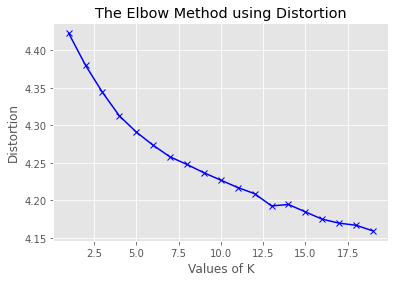

In [67]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')

In [78]:
km = KMeans(n_clusters=13).fit(X)
group_labels = km.labels_


In [90]:
x_vals, y_vals, _ = reduce_dimensions(model)

In [91]:
word_vectors_df = pd.DataFrame({'words': labels, 'groups': group_labels, 'tsne_X': x_vals, 'tsne_y': y_vals})

In [95]:
word_vectors_df.head()

,words,groups,tsne_X,tsne_y
0,group,11,-7.589090,-37.642509
1,house,6,-27.706060,-0.863550
2,republicans,6,-38.765160,-27.184383
3,sent,2,-18.528957,-2.220560
4,letter,2,34.854076,2.096471


In [94]:
word_vectors_df.to_csv('single_word_vectors.csv')

Text(0.5, 1.0, 'News Articles Word Vectors')

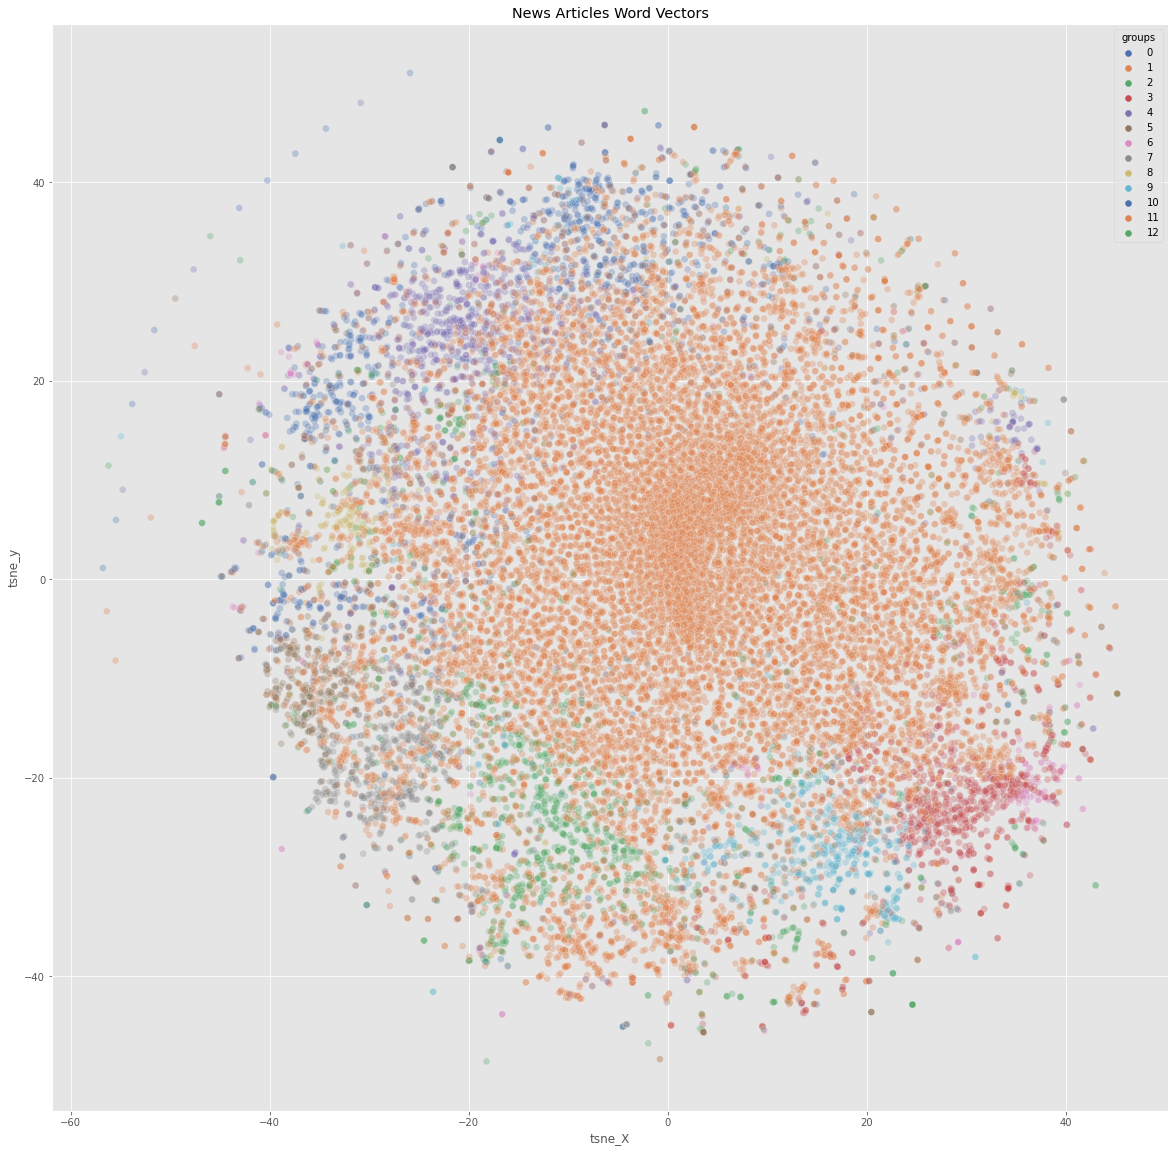

In [106]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=word_vectors_df, x='tsne_X', y='tsne_y', hue='groups', palette='deep',alpha=0.3, s=50)
plt.title('News Articles Word Vectors')